In [21]:
import tensorflow as tf 
import tensorflow.keras as tfk 
import numpy as np 
import matplotlib.pyplot as plt 
import os
from scipy.integrate import solve_ivp

import sys
from utils import *
sys.path.insert(1, "../src/")
from sindy_utils import *

from utils import *

seed = 42
tf.random.set_seed(seed)

## Model architecture

In [22]:
def build_encoder(input_shape, latent_dim = 1):
    encoder_inputs = tfk.Input(shape=(input_shape,)) 
    
    #initially following parameters outlined in sindy paper 
    activation = "sigmoid"
    x = tfk.layers.Dense(128, activation=activation, kernel_initializer = tfk.initializers.GlorotNormal(seed=seed))(encoder_inputs)
    x = tfk.layers.Dense(64, activation=activation, kernel_initializer = tfk.initializers.GlorotNormal(seed=seed))(x)
    x = tfk.layers.Dense(32, activation=activation, kernel_initializer = tfk.initializers.GlorotNormal(seed=seed))(x)
    z = tfk.layers.Dense(latent_dim, 
                         activation='sigmoid', 
                         kernel_initializer = tfk.initializers.GlorotNormal(seed=seed))(x)

    encoder = tfk.Model(encoder_inputs, z, name="encoder")
    return encoder


def build_decoder(output_shape, latent_dim = 1):
    decoder_inputs = tfk.Input(shape=(latent_dim,))
    
    #initially following parameters outlined in sindy paper 
    activation = "relu"
    x = tfk.layers.Dense(32, activation=activation, kernel_initializer = tfk.initializers.GlorotNormal(seed=seed))(decoder_inputs)
    x = tfk.layers.Dense(64, activation=activation, kernel_initializer = tfk.initializers.GlorotNormal(seed=seed))(x)
    x = tfk.layers.Dense(128, activation=activation, kernel_initializer = tfk.initializers.GlorotNormal(seed=seed))(x)
    reconstructed = tfk.layers.Dense(output_shape, 
                                     activation="sigmoid", 
                                     kernel_initializer = tfk.initializers.GlorotNormal(seed=seed))(x) #softmax for grayscale 
    

    decoder = tfk.Model(decoder_inputs, reconstructed, name="decoder")
    return decoder

In [23]:
#need to define activations for more flexible derivative taking 
encoder_activations = ['relu' for i in range(3)]
encoder_activations.append('sigmoid')
decoder_activations = ['relu' for i in range(3)]
decoder_activations.append('sigmoid')

print(encoder_activations, decoder_activations)

#i wish keras layers let you access the activation type but unfortunately not -- wait! 
#i can subclass a layer and during the init create a variable that lets me define its activation as a string
#... more in the notion file 

['relu', 'relu', 'relu', 'sigmoid'] ['relu', 'relu', 'relu', 'sigmoid']


In [24]:
class DAE(tfk.Model):
    def __init__(self, encoder, decoder, encoder_activations, decoder_activations, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.encoder_activations = encoder_activations
        self.decoder_activations = decoder_activations
        
        
        #stateful metrics 
        self.total_loss_tracker = tfk.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tfk.metrics.Mean(
            name="reconstruction_loss"
        )
        
        #see if we can implement a stateful sindy regression coefficients object 
        self.Xi = None
        

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
        ]
    
    def call(self, inputs):
        '''x, dx, ddx = inputs   

        #extract latent rep and project the time derivatives from input 
        z = self.encoder(x)
        dz, ddz = z_derivative2(self.encoder, inputs, self.encoder_activations) 
        
        #estimate derivatives with sindy -- assuming already fit 
        latent = (z,dz,ddz)'''
        
        pass 
        
        
    
    def sindy_fit(self, latent_info):
        """
        ols regression to determine & update the sindy coefficients 
        
        consider doing this manually so we are exposing the actual embeddings more; idea would to pivot this into 
        the (X'X)^{-1}X'Y formulation directly in the training step 
        """
        z, dz, ddz = latent_info
        Z = tf.squeeze(tf.stack((z,dz), axis=1), -1)#squeeze gets rid of extra dim
        
        #should be sufficient for identifying spring dynamics
        lib = sindy_library(Z.numpy(), poly_order = 2, include_sine = False) 
        
        #print(f'lib rank: {np.linalg.matrix_rank(lib)}, min dim: {min(lib.shape[0], lib.shape[1])}, invertible? {np.linalg.matrix_rank(lib)==min(lib.shape[0], lib.shape[1])}')

        b = tf.squeeze(tf.stack((ddz,dz), axis=1))
        
        #Xi = tf.linalg.lstsq(lib, b) #me 
        Xi = sindy_fit(lib, b.numpy(), 0.1) #sindy 
        
        self.Xi = tf.convert_to_tensor(Xi)
        
        lib = tf.convert_to_tensor(lib, dtype='float32')
        ddz_out = tf.linalg.matmul(lib,Xi)
        
        return ddz_out
        

## Data prep 

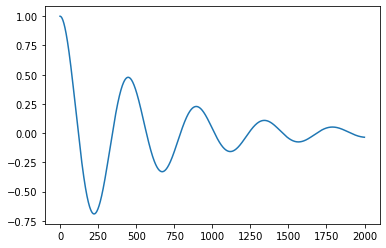

In [25]:
params = {'c':0.33, 'm':0.5, 'k':1}
x0 = [1, 0]
t = np.arange(0, 20, 0.01)

x_train = generate_spring_data(params, t, x0)

plt.plot(x_train[:,0])

In [26]:
#converting positional information into synthetic video 
dim = 51
x, dx, ddx = spring_to_movie(x_train[:,0], dt=0.01, dim = dim)
x = np.reshape(x, (x.shape[0], dim*dim))
dx = np.reshape(dx, (dx.shape[0], dim*dim))
ddx = np.reshape(ddx, (ddx.shape[0], dim*dim))

print(x.shape, dx.shape)

(2000, 2601) (2000, 2601)


In [27]:
#converting to a tensorflow dataset object 
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((x, dx, ddx))
train_dataset = train_dataset.shuffle(buffer_size=64, seed = seed).batch(batch_size)

next(iter(train_dataset))[0].shape #nice 

TensorShape([32, 2601])

## Training

In [28]:
dae = DAE(build_encoder(dim*dim, latent_dim = 1), 
          build_decoder(dim*dim, latent_dim = 1),
          encoder_activations,
          decoder_activations)

dae.compile(optimizer=tfk.optimizers.Adam(), run_eagerly=True)

In [29]:
model = dae

@tf.function
def train_step(data):
    x, dx, ddx = data
    #print(x.shape, dx.shape)
    
    with tf.GradientTape() as tape:
        #extract latent rep and derivatives 
        z = model.encoder(x)
        dz,ddz = z_derivative2(model.encoder, data, model.encoder_activations) 
        
        #sindy fit & estimate 
        latent = (z,dz,ddz)
        #z_est = model.sindy_fit(latent) #Xi now updated 
        
        #print(z)
        
        #reconstruction 
        reconstruction = model.decoder(z)

        #use BCE for black and white pics 
        reconstruction_loss = tf.reduce_mean(
                tfk.losses.binary_crossentropy(x, reconstruction)
        )

        total_loss = reconstruction_loss # + other terms 

    #de-facto 
    grads = tape.gradient(total_loss, model.trainable_weights)
    model.optimizer.apply_gradients(zip(grads, model.trainable_weights)) #will need to specify an optimizer 
    model.total_loss_tracker.update_state(total_loss)
    model.reconstruction_loss_tracker.update_state(reconstruction_loss)

    return {
        "loss": model.total_loss_tracker.result(),
        "reconstruction_loss": model.reconstruction_loss_tracker.result(),
    }

In [30]:
#run this for one epoch 
tf.config.run_functions_eagerly(False) #way faster without eager execution but you need it to interface with sindylib

epochs = 200
for epoch in range(epochs):

    #train step 
    for step, data in enumerate(train_dataset):
        losses = train_step(data)
    
    
    if(epoch%20 == 0):
        print(f'epoch: {epoch}\nlosses: {losses}') 

epoch: 0
losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.34560812>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.34560812>}
epoch: 20
losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.058960717>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.058960717>}
epoch: 40
losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.050269075>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.050269075>}
epoch: 60
losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.046806376>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.046806376>}
epoch: 80
losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.043963544>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.043963544>}
epoch: 100
losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.04205344>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.04205344>}
epoch: 120
losses: {

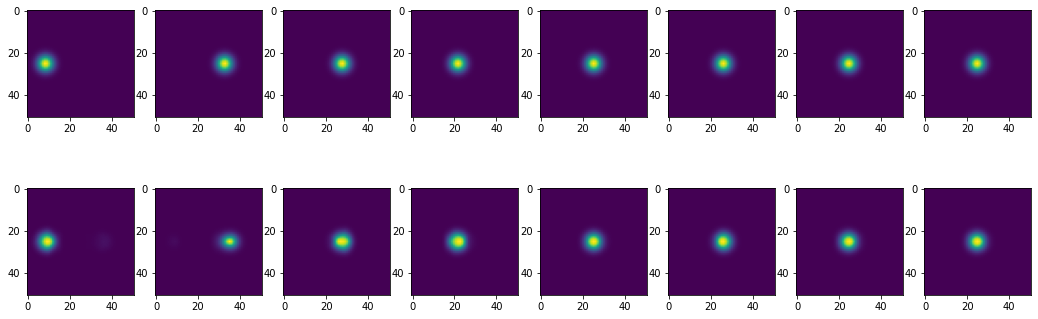

In [33]:
########## generate test data ##########
params2 = {'c':0.6, 'm':0.2, 'k':1}
x02 = [1, 1]
t2 = np.arange(0, 20, 0.1)
x_test = generate_spring_data(params2,t2,x02)

y, dy, ddy = spring_to_movie(x_test[:,0], dt=0.1, dim = dim)

y = np.reshape(y, (y.shape[0], dim*dim))
dy = np.reshape(dy, (dy.shape[0], dim*dim))
ddy = np.reshape(ddy, (ddy.shape[0], dim*dim))



########## predict #################
preds = dae.decoder(dae.encoder(y))

fig, axs = plt.subplots(2,8, figsize=(18,6))

j = 20
for i in range(8):
    axs[0][i].imshow(y[j*i].reshape(dim, dim))
    axs[1][i].imshow(preds[j*i].numpy().reshape(dim, dim))

In [34]:
dae.Xi

In both the following derivative functions our forward propogations depend on the activations in the model passed to the function call.  relu is pretty good all things considered but in our decoder layer we end with a sigmoid so we need to provide some flexibility 